# Projet 2

## Sommaire

► consigne </br>
► setup </br>
► analyse qualitative </br>
► analyse quantative </br>
► évaluation

***
# consigne

Mark, votre manager, vous a convié à une réunion pour vous présenter le projet d’expansion à l’international de l’entreprise. Il vous confie une première mission d’analyse exploratoire, pour déterminer si les données sur l’éducation de la banque mondiale permettent d’informer le projet d’expansion.

Voici les différentes questions que Mark aimerait explorer, que vous avez notées durant la réunion :

 - Quels sont les pays avec un fort potentiel de clients pour nos services ?
 - Pour chacun de ces pays, quelle sera l’évolution de ce potentiel de clients ?
 - Dans quels pays l'entreprise doit-elle opérer en priorité ?
Votre mission
Mark vous a donc demandé de réaliser une analyse pré-exploratoire de ce jeu de données. Il vous a transmis cet email à la suite de la réunion :

*Hello,*

*Les données de la Banque mondiale sont disponibles à l’adresse suivante :*

*https://datacatalog.worldbank.org/dataset/education-statistics*

*Ou en téléchargement direct à ce lien.*

*Je te laisse regarder la page d'accueil qui décrit le jeu de données. En résumé, l’organisme “EdStats All Indicator Query” de la Banque mondiale répertorie 4000 indicateurs internationaux décrivant l’accès à l’éducation, l’obtention de diplômes et des informations relatives aux professeurs, aux dépenses liées à l’éducation... Tu trouveras plus d'info sur ce site :*

*http://datatopics.worldbank.org/education/*

*Pour la pré-analyse, pourrais-tu :*

 - *Valider la qualité de ce jeu de données (comporte-t-il beaucoup de données manquantes, dupliquées ?)*
 - *Décrire les informations contenues dans le jeu de données (nombre de colonnes ? nombre de lignes ?)*
 - *Sélectionner les informations qui semblent pertinentes pour répondre à la problématique (quelles sont les colonnes contenant des informations qui peuvent être utiles pour répondre à la problématique de l’entreprise ?)*
 - *Déterminer des ordres de grandeurs des indicateurs statistiques classiques pour les différentes zones géographiques et pays du monde (moyenne/médiane/écart-type par pays et par continent ou bloc géographique)*
 
*Ton travail va nous permettre de déterminer si ce jeu de données peut informer les décisions d'ouverture vers de nouveaux pays. On va partager ton analyse avec le board, alors merci de soigner la présentation et de l'illustrer avec des graphiques pertinents et lisibles !*

Livrables attendus
 - Un notebook comportant les analyses pré-exploratoires réalisées (non cleané, pour comprendre votre démarche).
 - Un support de présentation pour la soutenance.

***
# Setup

### import des bibliothèques

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib.pyplot as plt
import missingno as msno
import ipywidgets as widgets

from datetime import datetime, timezone, timedelta, date
from IPython.display import display as Idisplay
from IPython.display import clear_output
from matplotlib import pylab

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

### import des données

In [2]:
EdStatsCountry = pd.read_csv("csv_data/EdStatsCountry.csv")
EdStatsCountry_Series = pd.read_csv("csv_data/EdStatsCountry-Series.csv")
EdStatsData = pd.read_csv("csv_data/EdStatsData.csv")
EdStatsFootNote = pd.read_csv("csv_data/EdStatsFootNote.csv")
EdStatsSeries = pd.read_csv("csv_data/EdStatsSeries.csv")

***
# Analyse Qualitative

premier coup d'oeuil avec une carte des liens entre les tables

![title](table_chart.png)

### affichage des données manquantes sous forme de matrice binaire (Noir = présent, Blanc = manquant)

In [3]:
Tables = [EdStatsCountry, EdStatsCountry_Series, EdStatsData, EdStatsFootNote, EdStatsSeries]
T_Names = ["EdStatsCountry", "EdStatsCountry-Series", "EdStatsData", "EdStatsFootNote", "EdStatsSeries"]
for t,n in zip(Tables, T_Names):
    t.name = n

def draw_missing_values(ds_str, fig, ax):
    t = Tables[T_Names.index(ds_str)]
    msno.matrix(t, ax=ax, sparkline=False)
    ax.set_title(t.name)
    fig.tight_layout(pad=2)

<IPython.core.display.Javascript object>


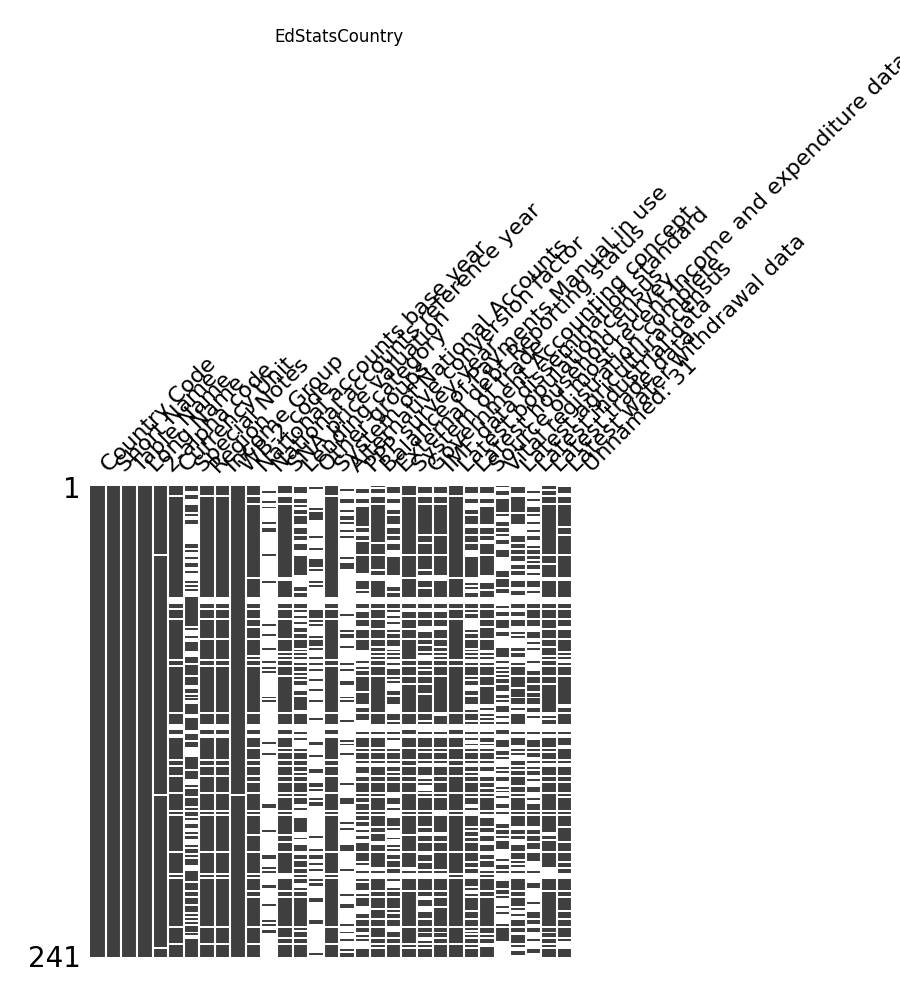

Dropdown(options=('EdStatsCountry', 'EdStatsCountry-Series', 'EdStatsData', 'EdStatsFootNote', 'EdStatsSeries'…

In [4]:
msnowidget = widgets.Dropdown(options=T_Names)

fig, ax = plt.subplots(figsize=(9,10))

def msnowidget_eventhandler(change):
    draw_missing_values(change.new, fig, ax)

msnowidget.observe(msnowidget_eventhandler, names='value')
Idisplay(msnowidget)
draw_missing_values("EdStatsCountry", fig, ax)

***
# Analyse Quantitative

préparation de tableaux utiles pour l'affichage

In [5]:
indicators = EdStatsSeries["Indicator Name"].to_numpy()
#liste des éléments de "Country Name" qui ne sont pas des états mais des aggrégats d'états
regions =  ['Arab World',
            'East Asia & Pacific',
            'East Asia & Pacific (all income levels)',
            'East Asia & Pacific (excluding high income)',
            'Europe & Central Asia',
            'Europe & Central Asia (all income levels)',
            'Europe & Central Asia (excluding high income)',
            'Euro area',
            'European Union',
            'Heavily indebted poor countries (HIPC)',
            'High income',
            'Latin America & Caribbean',
            'Latin America & Caribbean (all income levels)',
            'Latin America & Caribbean (excluding high income)',
            'Least developed countries: UN classification',
            'Low income',
            'Lower middle income',
            'Low & middle income',
            'Middle East & North Africa',
            'Middle East & North Africa (all income levels)',
            'Middle East & North Africa (excluding high income)',
            'Middle income',
            'North America',
            'OECD members',
            'South Asia',
            'Sub-Saharan Africa',
            'Sub-Saharan Africa (all income levels)',
            'Sub-Saharan Africa (excluding high income)',
            'Upper middle income',
            'World']
countries = EdStatsCountry["Table Name"].to_numpy()

Dates = [date(year, 1, 1) for year in list(range(1970,2018,1))+list(range(2020,2101,5))]
Dates_string = [str(d.year) for d in Dates]

préparation de fonctions pour l'extraction des données depuis les datasets

In [6]:
def get_Y_values(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Indicator Name` == @indicator & `Country Name` == @country")
    return Q[Dates_string].to_numpy().ravel()
    
def get_indi_missing(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Indicator Name` == @indicator")
    return Q[Dates_string].isna().mean(axis=1).to_numpy(), Q.isna().mean(axis=0)[Dates_string].to_numpy(), Q.reset_index().query("`Country Name`== @country").index[0]

def get_cty_missing(dataframe, indicator:str, country:str):
    Q = EdStatsData.query("`Country Name` == @country")
    return Q[Dates_string].isna().mean(axis=1).to_numpy(), Q.isna().mean(axis=0)[Dates_string].to_numpy(), Q.reset_index().query("`Indicator Name` == @indicator").index[0]

création de widgets pour l'affichage dynamique

In [7]:
options = [(d.strftime('%Y'), d) for d in Dates]
date_slider = widgets.SelectionRangeSlider(options=options,
                                           index=(0,55),
                                           description='Période',
                                           disabled=False)

indicators_combobox = widgets.Combobox(
    value='Population, total',
    placeholder='',
    options=list(indicators),
    description='Indicator',
    ensure_option=True,
    disabled=False
)

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

creation de l'objet qui gère l'affichage dynamique

In [8]:
# Cette classe encapsule la gestion de l'affichage dynamique des indicateurs et de leurs données manquantes
class Displayer :
    
    def __init__(self, DS, indi, country):
        self.dataset = DS
        self.indi = indi
        self.country = country
        self.X = np.array(Dates)
        self.d_start = min(self.X)
        self.d_end = max(self.X)
        self.mask = np.full(len(self.X), True)
        self.fig, self.ax = None, None
        self.fig1, self.ax1 = None, None
        self.fig2, self.ax2 = None, None
        self.out = widgets.Output()
        self.indi_miss = widgets.Output()
        self.cty_miss = widgets.Output()
    
    def change_dates(self, new_date_start, new_date_end):
        self.d_start = new_date_start
        self.d_end = new_date_end
        self._UPDATE_MASK()
    
    def change_country(self, new_country):
        self.country = new_country
        self._country_missing()
    
    def change_indi(self, new_indi):
        self.indi = new_indi
    
    def _UPDATE_MASK(self):
        self.mask = np.array([self.d_start <= date <= self.d_end for date in self.X])
    
    def _plot(self):
        self.out.clear_output()
        with self.out :
            if self.fig==None :
                self.fig, self.ax = plt.subplots(figsize=(9,6), 
                                                 num=f"{self.country}-{self.indi}")
            else :
                self.fig.set(label = f"{self.country}-{self.indi}")
            fig, ax = self.fig, self.ax
            ax.clear()
            ax.plot(self.X[self.mask], 
                    get_Y_values(self.dataset, self.indi, self.country)[self.mask],
                    zorder=1)

            ax.grid(zorder=0)
            fig.tight_layout()
            Idisplay(fig)
    
    def _indicator_missing(self):
        self.indi_miss.clear_output()
        with self.indi_miss :
            if self.fig1==None :
                self.fig1, self.ax1 = plt.subplots(3, 1, 
                                                   figsize=(9,35), 
                                                   height_ratios = [15,10,5], 
                                                   num=f"{self.indi[:50]}")
            else :
                self.fig1.set(label = f"{self.indi[:50]}")
            fig1, ax1 = self.fig1, self.ax1
            miss_tab, miss_date, cty_index = get_indi_missing(self.dataset, self.indi, self.country)
            N = len(miss_tab)
            
            ax1[0].clear()
            bars = ax1[0].barh(range(N), miss_tab/max(miss_tab))
            bars[cty_index].set_color('r')
            ax1[0].set_title(f'valeurs manquantes par pays')
            ax1[0].set_yticks([])
            ax1[0].set_ylim(-1, N+1)
            
            ax1[1].clear()
            bars = ax1[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax1[1].set_title(f'valeurs manquantes par année')
            ax1[1].set_ylim(-1, len(miss_date)+1)
            ax1[1].set_yticks(np.arange(len(Dates_string)), Dates_string)
            
            ax1[2].clear()
            ax1[2].pie([miss_tab.mean(), 1-miss_tab.mean()], 
                        labels=['missing', 'data'],
                        autopct='%1.1f%%')
            ax1[2].set_title(f'valeurs manquantes par pays -moyenne-')
            ax1[2].axis('equal')
            
            fig1.tight_layout()
            Idisplay(fig1)
    
    def _country_missing(self):
        self.cty_miss.clear_output()
        with self.cty_miss :
            if self.fig2==None :
                self.fig2, self.ax2 = plt.subplots(3, 1,
                                                   figsize=(9,115), 
                                                   height_ratios = [100,10,5],
                                                   num=f"{self.country}")
            else :
                self.fig2.set(label = f"{self.country}")
            fig2, ax2 = self.fig2, self.ax2
            miss_tab, miss_date, indi_index = get_cty_missing(self.dataset, self.indi, self.country)
            N = len(miss_tab)
            
            ax2[0].clear()
            bars = ax2[0].barh(range(N), miss_tab/max(miss_tab))
            bars[indi_index].set_color('r')
            ax2[0].set_title(f'valeurs manquantes par indicateur')
            ax2[0].set_yticks([])
            ax2[0].set_ylim(-1, N+1)
            
            ax2[1].clear()
            bars = ax2[1].barh(range(len(miss_date)), miss_date/max(miss_date))
            ax2[1].set_title(f'valeurs manquantes par année')
            ax2[1].set_ylim(-1, len(miss_date)+1)
            ax2[1].set_yticks(np.arange(len(Dates_string)), Dates_string)
            
            ax2[2].clear()
            ax2[2].pie([miss_tab.mean(), 1-miss_tab.mean()], 
                        labels=['manquant', 'donnees'],
                        autopct='%1.1f%%')
            ax2[2].set_title(f'valeurs manquantes par indicateur -moyenne-')
            ax2[2].axis('equal')
            
            fig2.tight_layout()
            Idisplay(fig2)
    
    def display(self):
        self._plot()
        self._indicator_missing()
        self._country_missing()

mise en relation de l'objet qui gère l'affichage et des widgets qui récupèrent les données

In [9]:
Data_displayer = Displayer(EdStatsData, "Population, total", "France")

def date_slider_eventhandler(change):
    Data_displayer.change_dates(*change.new)
    Data_displayer.display()
def indicators_combobox_eventhandler(change):
    Data_displayer.change_indi(change.new)
    Data_displayer.display()
def countries_combobox_eventhandler(change):
    Data_displayer.change_country(change.new)
    Data_displayer.display()

date_slider.observe(date_slider_eventhandler, names='value')
indicators_combobox.observe(indicators_combobox_eventhandler, names='value')
countries_combobox.observe(countries_combobox_eventhandler, names='value')

In [10]:
tab = widgets.Tab()
tab.children = [widgets.VBox([Data_displayer.out, date_slider, indicators_combobox, countries_combobox]), 
                widgets.VBox([Data_displayer.indi_miss, indicators_combobox]),
                widgets.VBox([Data_displayer.cty_miss, countries_combobox])]
tab.titles = ("plot", "indicator", "country")
Idisplay(tab)
Data_displayer.display()
print("")

***
# Evaluation

### selection de la periode d'analyse

on se concentre sur la partie entre 2005 et 2015 car c'est une période à la fois suffisamment récente et les années autour de 2010 sont les plus renseignées au niveau des indicateurs.

<IPython.core.display.Javascript object>


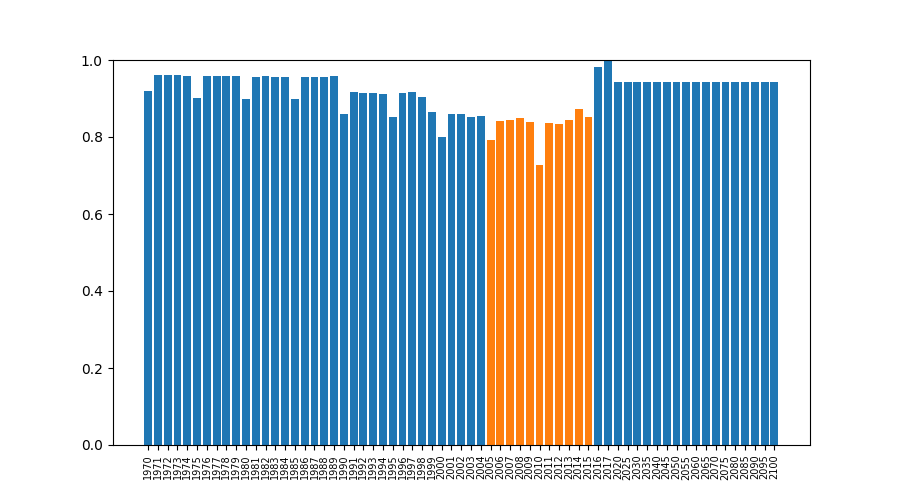

In [11]:
fig4, ax4 = plt.subplots(figsize=(9,5))

ax4.bar(np.arange(65), 
        np.isnan(np.array(EdStatsData.to_numpy()[:,4:-1], dtype=float)).mean(axis=0), 
        color=['C00']*35+['C01']*11+['C00']*20)
ax4.set_xticks(np.arange(65), labels=Dates_string, rotation=90, fontsize=7)
ax4.set_ylim(0,1)
fig4.set(label='Données manquantes par année')

etude = Dates_string[35:46]

## repérage des indicateurs

In [12]:
def stats_indicator(indi:str):
    """
    prend un indicateur et donne ses statistiques sur tout le dataset

    :param indi: l'indicateur considéré
    :return: Un dataset généré avec pd.DataFrame.describe()
    """
    Q = EdStatsData.query("`Indicator Name` == @indi")
    return pd.DataFrame(Q[~Q["Country Name"].isin(regions)][Dates_string].to_numpy().ravel()).dropna().round(5).describe()

### communication

#### Internet users (per 100 people)

In [13]:
EdStatsSeries.query("`Indicator Name` == 'Internet users (per 100 people)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
611,IT.NET.USER.P2,Infrastructure: Communications,Internet users (per 100 people),NaN,Internet users are individuals who have used t...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,Please cite the International Telecommunicatio...,"International Telecommunication Union, World T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
stats_indicator('Internet users (per 100 people)')

,0
count,4832.000
mean,21.274
std,26.834
min,0.000
25%,0.500
50%,7.000
75%,36.325
max,98.324


#### Personal computers (per 100 people)

In [15]:
EdStatsSeries.query("`Indicator Name` == 'Personal computers (per 100 people)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
610,IT.CMP.PCMP.P2,Infrastructure: Communications,Personal computers (per 100 people),NaN,Personal computers are self-contained computer...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,Restricted use: Please cite the International ...,"International Telecommunication Union, World T...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
stats_indicator('Personal computers (per 100 people)')

,0
count,2390.000
mean,10.039
std,15.817
min,0.000
25%,0.727
50%,3.438
75%,11.932
max,96.171


### education

Les valeurs éducatives doivent êtres pondérées par la population pour donner des résultats exploitables

In [17]:
def get_lims(DS, indi:str):
    Q = DS.query("`Indicator Name`==@indi")[etude].to_numpy().ravel()
    Q = Q[~np.isnan(Q)]
    return Q.min(), Q.max()

def get_weighted(DS, indi:str, by:str='Population, total'):
    """
    Cette fonction utilise un dataset et un indicateur pour renvoyer un nouveau dataset des données de l'indicateur
    pondérées par la valeur de la population chaque année.

    :param DS: le dataset
    :param indi: l'indicateur qu'il faut pondérer
    :return: Le dataset résultat avec les mêmes colonnes mais de nouvelles lignes.
    """
    A = DS.copy()
    A.sort_values("Country Name", 0)
    Pop = A.query("`Indicator Name` == @by")
    Indi = A.query("`Indicator Name` == @indi")
    Pop.index = Indi.index = pd.Index(range(len(DS), len(DS)+len(Pop)))
    Indi[etude] = Indi[etude].div(Pop[etude])
    Indi["Indicator Name"] = Indi["Indicator Name"] + " weighted by population"
    return Indi

#### Enrolment in primary education, both sexes (number)

In [18]:
EdStatsSeries.query("`Indicator Name` == 'Enrolment in primary education, both sexes (number)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2246,SE.PRM.ENRL,Primary,"Enrolment in primary education, both sexes (nu...",NaN,Total number of students enrolled in public an...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
stats_indicator('Enrolment in primary education, both sexes (number)')

,0
count,7369.000
mean,3248954.905
std,12615284.041
min,1008.000
25%,116756.000
50%,504226.000
75%,2200335.000
max,150940992.000


In [20]:
EdStatsData = pd.concat((EdStatsData, get_weighted(EdStatsData, 'Enrolment in primary education, both sexes (number)', by='Population, ages 13-19, total')))

Maximum : 0.2531978696990211 Uganda 2009

#### Enrolment in secondary education, both sexes (number)

In [21]:
EdStatsSeries.query("`Indicator Name` == 'Enrolment in secondary education, both sexes (number)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2294,SE.SEC.ENRL,Secondary,"Enrolment in secondary education, both sexes (...",NaN,Total number of students enrolled at public an...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
stats_indicator('Enrolment in secondary education, both sexes (number)')

,0
count,6274.000
mean,2219783.735
std,8482689.711
min,0.000
25%,52523.750
50%,342377.500
75%,1156794.250
max,129542056.000


In [23]:
EdStatsData = pd.concat((EdStatsData, get_weighted(EdStatsData, 'Enrolment in secondary education, both sexes (number)', by='Population, ages 13-19, total')))

Maximum : 0.20126769717825674 West Bank and Gaza 2006

#### Enrolment in tertiary education, all programmes, both sexes (number)

In [24]:
EdStatsSeries.query("`Indicator Name` == 'Enrolment in tertiary education, all programmes, both sexes (number)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
2332,SE.TER.ENRL,Tertiary,"Enrolment in tertiary education, all programme...",NaN,The total number of students enrolled at publi...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,UNESCO Institute for Statistics,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
stats_indicator('Enrolment in tertiary education, all programmes, both sexes (number)')

,0
count,5475.000
mean,679321.702
std,2399902.569
min,0.000
25%,10235.500
50%,98122.000
75%,337453.500
max,43367392.000


In [26]:
EdStatsData = pd.concat((EdStatsData, get_weighted(EdStatsData, 'Enrolment in tertiary education, all programmes, both sexes (number)', by='Population, ages 13-19, total')))

Maximum : 0.08729190749860695 Cuba 2008

### economics

#### Income Group

In [27]:
income_groups = pd.unique(EdStatsCountry["Income Group"].dropna())
income_int = [3, 0, 2, 1, 4]

def income_cat(x):
    '''
    récupère une chaine de caractère de catégorie et renvoie l'entier correspondant
    ces catégories sont numérotées de 0 à 4 classées par ordre croissant
    Low income < Lower middle income < Upper middle income < High income: nonOECD < High income: OECD
    '''
    if x!=x : #vrai ssi x est NaN
        return x
    else :
        return income_int[list(income_groups).index(x)]

In [28]:
pd.DataFrame(EdStatsCountry["Income Group"].value_counts())

,Income Group
Upper middle income,55
Lower middle income,50
High income: nonOECD,44
Low income,34
High income: OECD,31


#### GNI per capita, Atlas method (current US$)

In [29]:
EdStatsSeries.query("`Indicator Name` == 'GNI per capita, Atlas method (current US$)'")

,Series Code,Topic,Indicator Name,Short definition,Long definition,Unit of measure,Periodicity,Base Period,Other notes,Aggregation method,...,Notes from original source,General comments,Source,Statistical concept and methodology,Development relevance,Related source links,Other web links,Related indicators,License Type,Unnamed: 20
1668,NY.GNP.PCAP.CD,Economic Policy & Debt: National accounts: Atl...,"GNI per capita, Atlas method (current US$)",NaN,GNI per capita (formerly GNP per capita) is th...,NaN,Annual,NaN,NaN,Weighted average,...,NaN,NaN,"World Bank national accounts data, and OECD Na...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
stats_indicator('GNI per capita, Atlas method (current US$)')

,0
count,7356.000
mean,7974.770
std,14512.733
min,60.000
25%,620.000
50%,2210.000
75%,8000.000
max,186080.000


Maximum : 186080.0 Monaco 2008

# notation

création des fonctions de calcul de notes

In [31]:
#chaque indicateur est associé à ses valeurs limites pour les calculs
selection =[('Internet users (per 100 people)', 0, 100, False),
            ('Personal computers (per 100 people)', 0, 100, False),
            ('Income Group', 0, 4, False),
            ('GNI per capita, Atlas method (current US$)', None, None, False),
            ('Population, total', None, None, True),
            ('Population growth (annual %)', None, None, True),
            ('Population, ages 13-19, total', None, None, True),
            ('Enrolment in primary education, both sexes (number) weighted by population', None, None, False),
            ('Enrolment in secondary education, both sexes (number) weighted by population', None, None, False),
            ('Enrolment in tertiary education, all programmes, both sexes (number) weighted by population', None, None, False)]

#MultiIndex pour l'affichage plus joli en dataframe
Mindex = [('communication', 'Internet users (per 100 people)'),
          ('communication', 'Personal computers (per 100 people)'),
          ('economics',     'Income Group'),
          ('economics',     'GNI per capita, Atlas method (current US$)'),
          ('demographics',  'Population, total'),
          ('demographics',  'Population growth (annual %)'),
          ('demographics',  'Population, ages 13-19, total'),
          ('education',     'Enrolment in primary education, both sexes (number) weighted by population'),
          ('education',     'Enrolment in secondary education, both sexes (number) weighted by population'),
          ('education',     'Enrolment in tertiary education, all programmes, both sexes (number) weighted by population'),
          ('divers',        'moyenne generale')]

In [32]:
def list_normalise(L, m, M):
    '''normalise la liste L entre m et M (m<M)'''
    L = L[~np.isnan(L)]
    return (L-m)/(M-m)

def point_normalise(p, m, M):
    '''normalise le point de données p entre m et M (m<M)'''
    return (p-m)/(M-m)

def note_indicateur(country, indicator, m=0, M=1, use_log=False):
    """
    Cette fonction prend un pays et trois informations d'indicateur : nom, portée min, portée max.
    Elle renvoie alors la note de l'indicateur pour le pays comme la moyenne des valeurs normalisées entre 2005 et 2015

    :param country: le nom du pays
    :param indicator: l'indicateur dont on veut calculer la note
    :param m: minimum de l'indicateur, 0 par défaut (optionnel)
    :param M: maximum de l'indicateur, 1 par défaut (optionnel)
    :return: La note de l'indicateur, moyenne des valeurs sur la période d'étude.
    """
    if m==None :
        m, M = get_lims(EdStatsData, indicator)
    
    if indicator != 'Income Group': 
        Y = get_Y_values(EdStatsData, indicator, country)
        if use_log :
            return list_normalise(np.log(Y[35:46]-m), 0, np.log(M-m)).mean()
        else :
            return list_normalise(Y[35:46], m, M).mean()
    else :
        Y=EdStatsCountry.query("`Table Name`==@country")
        return point_normalise(income_cat(Y["Income Group"].iloc[0]), m, M)

def note(country, PB=None):
    """
    Cette fonction prend en entrée un pays et renvoie un dataset de chaque note qu'elle a obtenu pour tous les indicateurs,
    plus le score moyen
    
    :param country: Le pays à analyser
    :param PB: un paramètre optionnel pour faire évoluer une barre de chargement
    :return: Un dataset des notes.
    """
    if PB :
        PB.value = PB.value+1
    
    bull_index = pd.MultiIndex.from_tuples(Mindex, names=["categorie", "indicateur"])
    V = np.array([round(20*note_indicateur(country, *s), 2) for s in selection])
    res = pd.DataFrame(list(V)+[V[~np.isnan(V)].mean()], 
                       index=bull_index, 
                       columns=["note"],
                       dtype=float)
    res.columns.name = country
    return res

def moyenne_indi(DS, indi:str):
    Q = DS.query("`Indicator Name`==@indi")[etude]

affichage du bulletin de notes pour un pays

In [33]:
bulletin = note('France')

note_out = widgets.Output()
with note_out :
    Idisplay(bulletin)

countries_combobox = widgets.Combobox(
    value='France',
    placeholder='',
    options=list(countries),
    description='Country',
    ensure_option=True,
    disabled=False
)

def countries_combobox_eventhandler(change):
    bulletin = note(change.new)
    note_out.clear_output()
    with note_out :
        Idisplay(bulletin)

countries_combobox.observe(countries_combobox_eventhandler, names='value')

Idisplay(countries_combobox, note_out)

Combobox(value='France', description='Country', ensure_option=True, options=('Aruba', 'Afghanistan', 'Angola',…

Output()

Calcul de la note pour chaque pays

In [34]:
progressBar = widgets.IntProgress(value=0,
                                  min=0,
                                  max=len(countries),
                                  description='Chargement:',
                                  bar_style='',
                                  style={'bar_color': 'blue'},
                                  orientation='horizontal')

Idisplay(progressBar)

EdStatsCountry["Note"]=EdStatsCountry["Table Name"].apply(lambda x:note(x, progressBar).loc["divers", "moyenne generale"])

IntProgress(value=0, description='Chargement:', max=241, style=ProgressStyle(bar_color='blue'))

Affichage des 10 pays les mieux notés

In [35]:
EdStatsCountry.sort_values(["Note", "Table Name"], ascending=[False, True]).reset_index()[["Table Name", "Note"]].head(10)

,Table Name,Note
0,Curaçao,15.000
1,Faeroe Islands,15.000
2,Australia,13.470
3,Netherlands,13.320
4,Monaco,13.236
5,United States,13.206
6,Canada,13.169
7,Norway,13.157
8,Sweden,13.145
9,United Kingdom,13.020
